# **Gamma Ray Spectroscopy**

In [1]:
from sort_csv import *
from process_functions import * 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scaling Data Sets

#### Process raw data

In [2]:
bg_noise, bg_noise_uncer = input_bg()
factor, factor_uncer, df_correction  = calculate_correction_factor()
display(df_correction)

/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: overflow encountered in power
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)
/home/dio/Desktop/PHYS128AL/Gamma_Spectroscopy/sort_csv.py:100: RuntimeWarning: invalid value encountered in multiply
  factor = elasped_time_correction * np.e**(activity * t_elasped) * np.e**(-activity * unknown_second)


,Unknown,Cs137,Na22,Co57,Co60,Cd109,Ba133,Eu152,Zn65,Mn54
half_life / s,86400.0,948602880.0,81993600.0,23478336.0,166194720.0,39864960.0,334281600.0,426366720.0,21075552.0,26956800.0
produce_date,2019-03-01,2022-11-01,2022-11-03,2022-11-03,2023-01-18,2022-12-16,2023-01-18,2022-09-07,2022-12-01,2019-03-01
t_exp / s,202.07,164.03,108.6,115.54,152.04,143.15,77.2,112.9,83.58,86.05
corr_factor,1.0,1.131907,0.69769,0.056887,0.79703,0.175973,2.029917,1.494032,0.049144,2.348286
uncertainty,1.0,0.001859,0.020903,0.013818,0.008403,0.015927,0.005005,0.003886,0.012178,0.066689


In [3]:
file_name, energy, countss, countss_uncer = read_data(bg_noise, bg_noise_uncer, factor, factor_uncer, plotting=[])

# Spectral Analysis

#### Find the coordinate of the max counts 

Text(0.5, 0, 'Energy / keV')

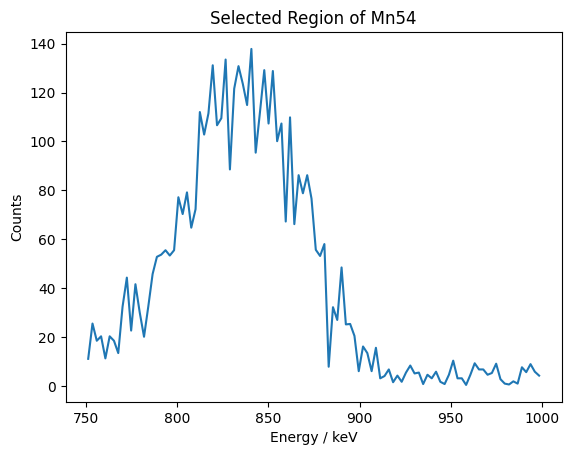

In [4]:
selected_ele = "Mn54"
y = countss[file_name.index(selected_ele)]
x = energy
x_min = 750
x_max = 1000
x_data, y_data = select_reg(x_min, x_max, x, y)
plt.plot(x_data, y_data)
plt.title("Selected Region of Mn54")
plt.ylabel("Counts")
plt.xlabel("Energy / keV")

In [5]:
x_min = 800
x_max = 900
energy_max, counts_max = find_max(x_min, x_max, x_data, y_data)
print(f"The maximum counts of {selected_ele} at range {x_min}keV to {x_max}keV\n"
      f"Located at energy {energy_max}keV, with a total counts of {counts_max}")

The maximum counts of Mn54 at range 800keV to 900keV
Located at energy 840.6913580246913keV, with a total counts of 137.8383560816767


#### Gaussian fitting to find spectral properties

N: 6097.838489978558 with uncertainty = 1476.666975515151
Center: 839.8498891535348 with uncertainty = 2.3209024589047327
Peak: 97.4409032536814


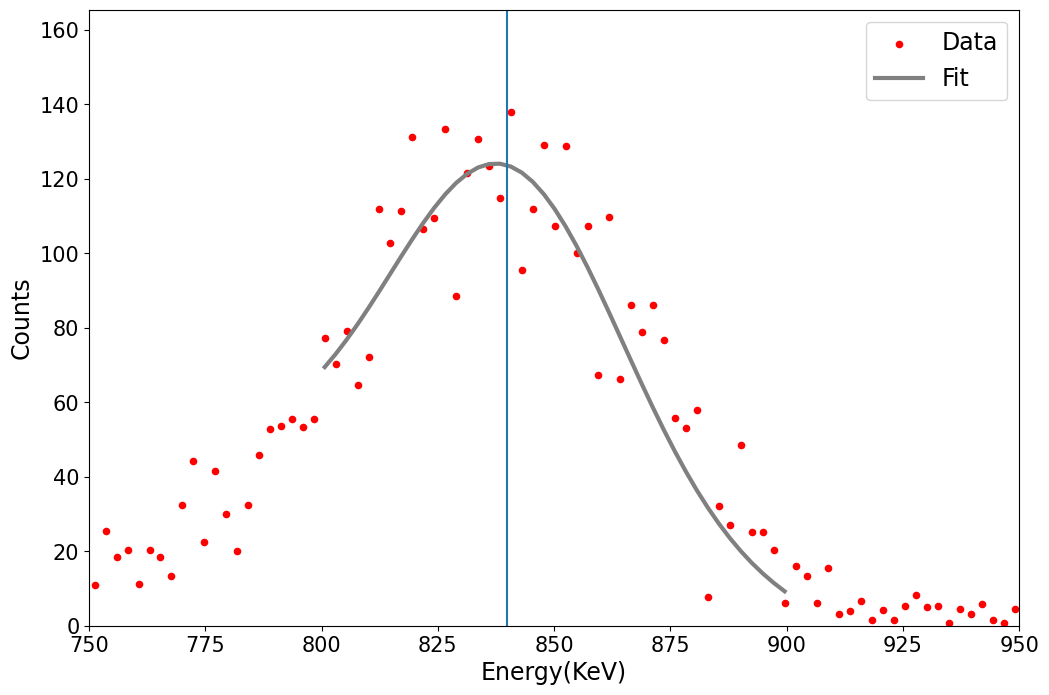

In [6]:
gaussian_fit(x_min, x_max, x_data, y_data)

## Least Square Prediction on Composition

In [7]:
least_square_weights(file_name, energy, 
                     countss, countss_uncer, 
                     cond=0.05, plotting=True)

ValueError: `sigma` has incorrect shape.

In [10]:
pred = np.linspace(0, 1000, 10000)
pred[np.arange(0, int(len(pred)), int(len(pred)/10))]

array([  0.      , 100.010001, 200.020002, 300.030003, 400.040004,
       500.050005, 600.060006, 700.070007, 800.080008, 900.090009])

In [29]:
def func(x, a, b, c, d, e, f, g, h, i):
    w = np.array([a, b, c, d, e, f, g, h, i])
    return np.dot(w, x)


def least_square_weights(file_name, energy, countss, countss_uncer, cond=0.05, plotting=True):
    unknown = countss[0]
    samples = np.array(countss[1:])
    popt, pcov = curve_fit(func, samples,
                           unknown, p0=[1, 0, 0, 0, 0, 0, 0, 0, 0], 
                           sigma=None, bounds=(0, 1))

    unknown_sample = countss[0]
    sample_counts = np.array(countss[1:])
    sample_counts_uncer = np.array(countss_uncer[1:])
    pred_name = np.array(file_name[1:])
    condition = np.where(popt >= cond)

    print("The predictions are", pred_name[condition])
    print("With proportion of", popt[condition])

    select_prop = popt[condition]
    select_samples = sample_counts[condition]
    select_samples_uncer = sample_counts_uncer[condition]

    pred = np.zeros(len(unknown_sample))
    pred_uncer = np.zeros(len(unknown_sample))
    for i in range(len(select_samples)):
        pred = pred + select_prop[i] * select_samples[i]
        pred_uncer = np.sqrt(np.square(pred_uncer) + np.square(select_samples_uncer[i]))

    
    pred_uncer = pred_uncer / pred
    pred = np.log(pred)
    unknown_sample = np.log(unknown_sample)


    pick_points = np.arange(int(len(pred)/10), int(len(pred)/2), int(len(pred)/30))
    x = energy[pick_points]
    y = pred[pick_points]
    y_err = pred_uncer[pick_points]

    if plotting == True:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.plot(energy, unknown_sample, label="Unknown")
        ax.plot(energy, pred, label="Predition from least square")
        ax.errorbar(x, 
                    y, 
                    yerr=y_err, 
                    ecolor="k", 
                    markerfacecolor="black", 
                    markeredgecolor="black", 
                    markersize=0.2,
                    fmt="o", 
                    capthick=1.5, 
                    capsize=2)
        ax.set_xlabel("Energy / keV")
        ax.set_ylabel("log(Counts)")
        ax.legend()


The predictions are ['Cs137' 'Cd109' 'Zn65' 'Mn54']
With proportion of [0.51919045 0.51119745 0.61651835 0.09400299]


/tmp/ipykernel_94654/2107298040.py:33: RuntimeWarning: invalid value encountered in true_divide
  pred_uncer = pred_uncer / pred
/tmp/ipykernel_94654/2107298040.py:34: RuntimeWarning: divide by zero encountered in log
  pred = np.log(pred)
/tmp/ipykernel_94654/2107298040.py:35: RuntimeWarning: divide by zero encountered in log
  unknown_sample = np.log(unknown_sample)


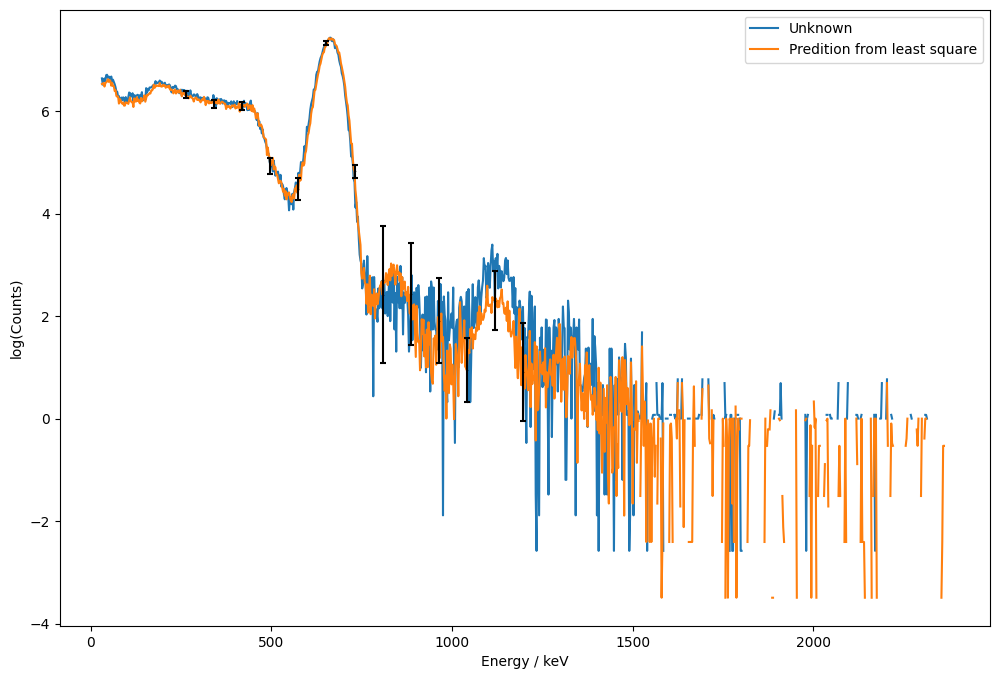

In [30]:
least_square_weights(file_name, energy, 
                     countss, countss_uncer, 
                     cond=0.05, plotting=True)

0.022360679774997897